## Explore board extraction results

In [1]:
import keras
import matplotlib.pyplot as plt
from train_board_extractor import train_generator, valid_generator
from board_extractor import extract_board, fix_mask, extract_perspective, find_quadrangle, rotate_quadrangle, scale_approx
import data
import numpy as np
import cv2
import u_net as unet

image_dir = "../data/board_extraction/images/"
mask_dir = "../data/board_extraction/masks/"


Using Theano backend.


In [2]:
#load model

model = unet.get_unet_256()
model.load_weights('../../weights/best_weights.hdf5')

### Training data

In [3]:
# set up the data generator

from train_board_extractor import train_generator, valid_generator, load_image_and_mask_ids
from sklearn.model_selection import train_test_split

ids_all = load_image_and_mask_ids()
_, ids_valid_split = train_test_split(ids_all, test_size=0.2, random_state=42)

g = valid_generator(ids_valid_split, batch_size=5)

In [14]:
#get batch of training data

image_batch, mask_batch = next(g)

print(image_batch.shape)
print(mask_batch.shape)

# predict and process data

SIZE = (256, 256)
predicted_mask_batch = model.predict(image_batch)
predicted_masks = list(map(lambda x: fix_mask(x).reshape(SIZE), predicted_mask_batch))

(5, 256, 256, 3)
(5, 256, 256, 1)


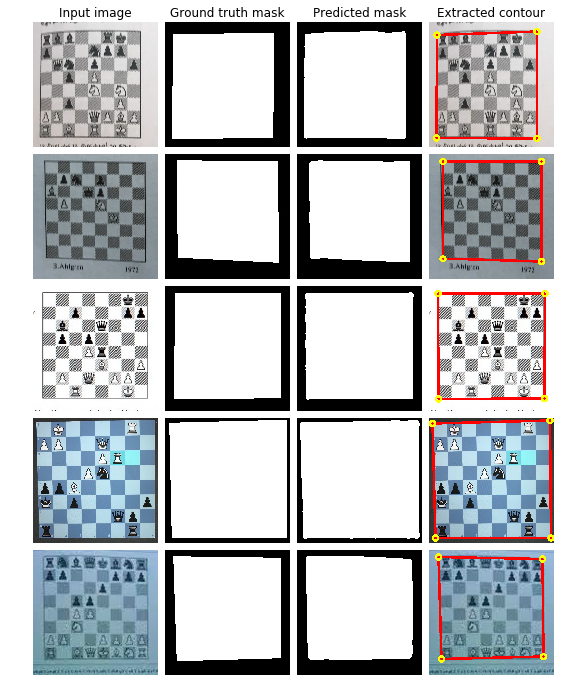

In [15]:
# plot training data grid
# Training img | ground truth mask | pred mask | Approximated contour (or fail)

from mpl_toolkits.axes_grid1 import ImageGrid

rows = 5
cols = 4

fig = plt.figure(1, figsize=(12, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 label_mode=None
                 )

for i in range(rows):

    # get images
    raw = image_batch[i]
    image = np.copy(raw)
    image *= 255
    image = image.astype(np.uint8)
    mask = mask_batch[i].reshape(SIZE)
    predicted_mask = predicted_masks[i]
    
    approx = find_quadrangle(predicted_mask)
    #orig_size = (raw.shape[0], raw.shape[1])
    #approx = scale_approx(approx, orig_size)
    #approx = np.array(approx, dtype=np.int32)

    cv2.drawContours(image, [approx], -1, (255, 0, 0), thickness=3)

    for p in approx:
        cv2.circle(image, (p[0][0], p[0][1]), 5, (255, 255, 0), thickness=3)

    # plot row
    ax1 = grid[cols*i]
    ax1.imshow(raw)
    ax1.axis("off")
    

    ax2 = grid[cols*i+1]
    ax2.imshow(mask, cmap="gray")
    ax2.axis("off")

    ax3 = grid[cols*i+2]
    ax3.imshow(predicted_mask, cmap="gray")
    ax3.axis("off")

    ax4 = grid[cols*i+3]
    ax4.imshow(image)
    ax4.axis("off")
    
    if i == 0:
        ax1.set_title("Input image")
        ax2.set_title("Ground truth mask")
        ax3.set_title("Predicted mask")
        ax4.set_title("Extracted contour")

#plt.savefig("../../img/training_extraction.png", bbox_inches="tight")
plt.show()



### Test data

Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE
Extracting board...
Extracting board... DONE


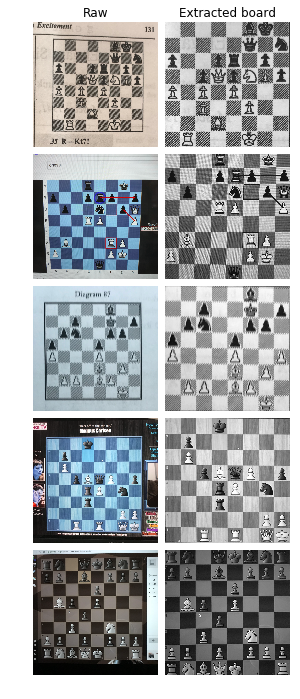

In [36]:
# Plot grid of test examples in the form: 
# raw img | extracted board (or fail)
from util import listdir_nohidden
import random

rows = 5
cols = 2

fig = plt.figure(2, figsize=(12, 12))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(rows, cols),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 share_all=True,
                 label_mode=None
                 )

raw_dir = "../../data/raw/"

raw_imgs = listdir_nohidden(raw_dir)

raw_batch = np.random.choice(raw_imgs, rows)

raw_imgs = list(map(lambda f: cv2.imread(raw_dir + f), raw_batch))
resized_imgs = list(map(lambda im: cv2.resize(im, SIZE, interpolation=cv2.INTER_AREA), raw_imgs))
resized_imgs2 = list(map(lambda im: cv2.resize(im, (512, 512), interpolation=cv2.INTER_AREA), raw_imgs))

for i in range(rows):
    try:
        board = extract_board(resized_imgs[i], raw_imgs[i], model)
    except Exception as e:
        print(e)
    
    ax1 = grid[cols*i]
    ax1.imshow(resized_imgs2[i])
    ax1.axis("off")
    
    ax2 = grid[cols*i+1]
    ax2.imshow(board, cmap="gray")
    ax2.axis("off")
    
    if i == 0:
        ax1.set_title("Raw")
        ax2.set_title("Extracted board")
    
plt.savefig("../../img/test_extraction.png", bbox_inches="tight")
plt.show()
    